In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Create Database Connection
#engine = create_engine('sqlite:///../Resources/database.sqlite')
#Base.metadata.create_all(engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
Measurement

# Exploratory Climate Analysis

sqlalchemy.ext.automap.measurement

2017-11-02


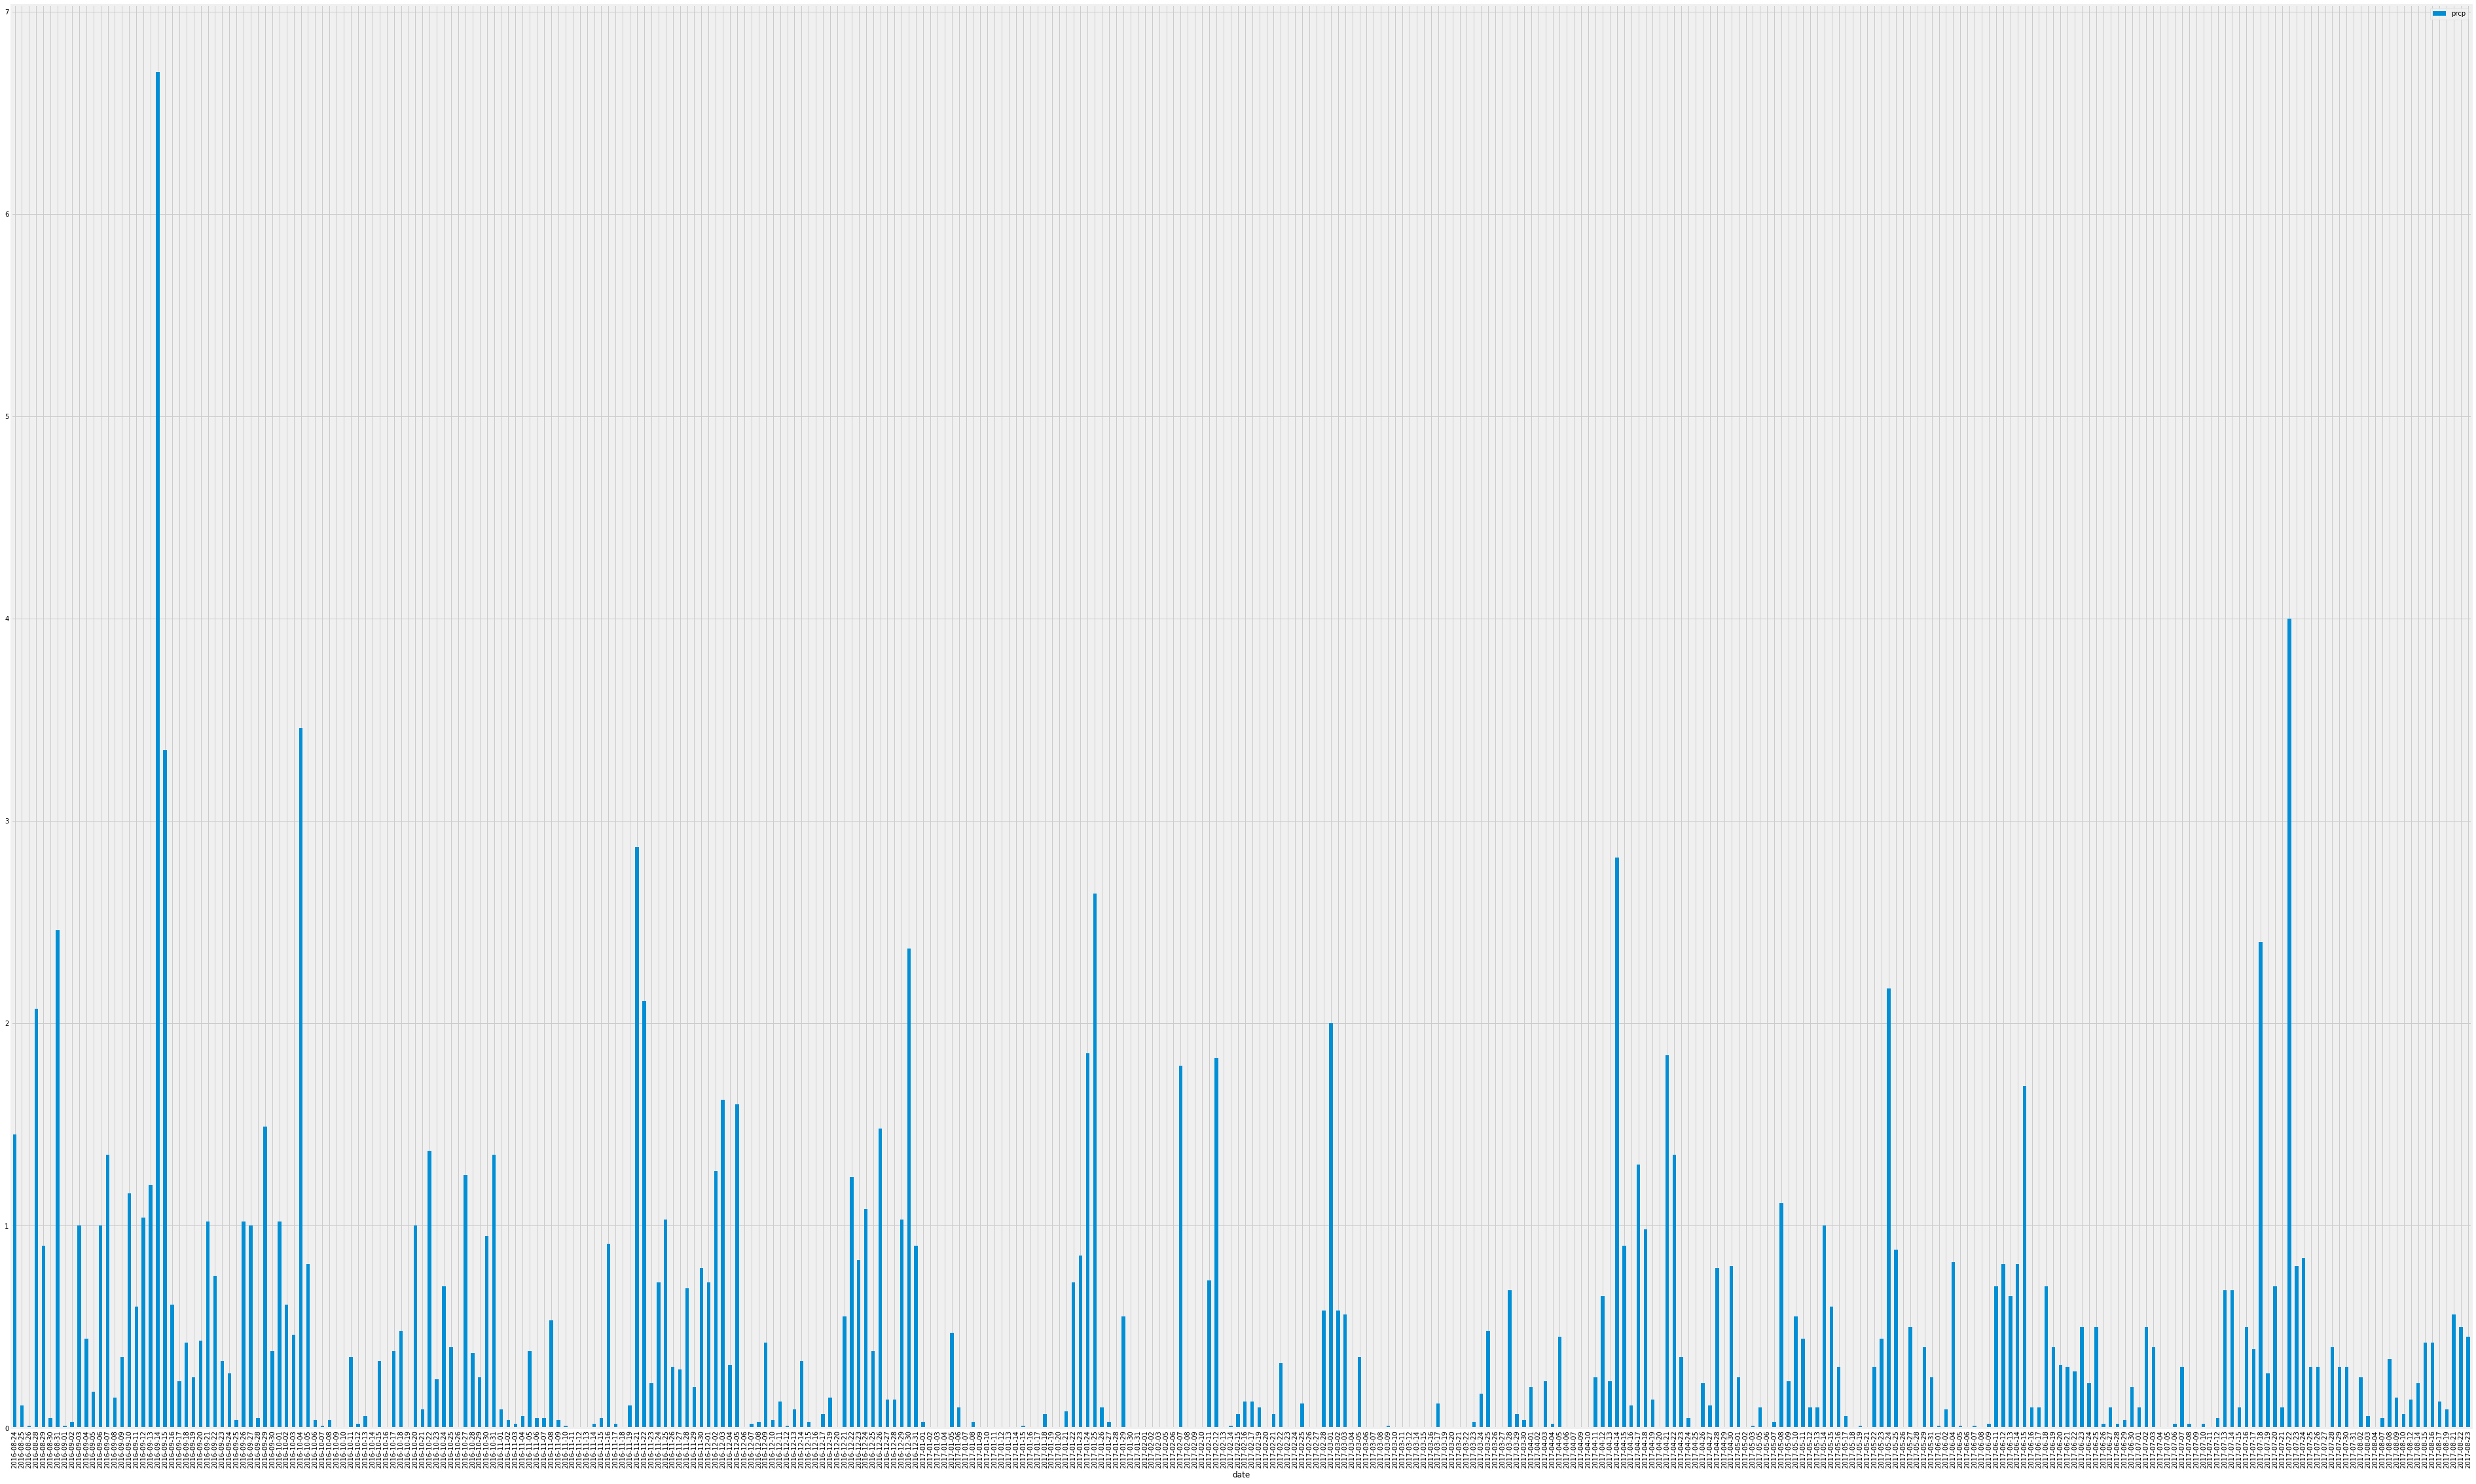

In [11]:
# Calculate the date 1 year ago from today
year_ago = dt.date.today() - dt.timedelta(days=365)
print(year_ago)
sel = [Measurement.date, 
       Measurement.prcp]
# Perform a query to retrieve the data and precipitation scores
precip_twelve_mo =session.query(*sel).filter(Measurement.date > '2016-08-23').group_by(Measurement.date).order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame 
df = pd.DataFrame(precip_twelve_mo, columns=['date', 'prcp'])
df.dropna(inplace=True)
df.drop_duplicates(keep='first',inplace=True)
# Set the index to the date column
df.set_index('date', inplace=True)
# Sort the dataframe by date
df.sort_index(inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data 
# Rotate the xticks for the dates

ax = df.plot.bar(figsize=(60,40),rot=90,)



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,344.000000
mean,0.431308
std,0.705240
min,0.000000
25%,0.010000
50%,0.140000
75%,0.565000
max,6.700000


In [13]:
# How many stations are available in this dataset?
# Total stations
session.query(func.count(Station.station)).all()

[(9)]

In [14]:
activity=func.count(Measurement.prcp)
sel = [Measurement.station, 
      activity]
results=[]
for row in session.query(*sel).group_by(Measurement.station).order_by(activity.desc()).all():
     #session.query(*sel).group_by(Measurement.station).order_by(activity.desc()).first():
    results.append(row)
results

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [15]:
# What are the most active stations?
# List the stations and the counts in descending order.
sel = [Measurement.station, 
      func.count(Measurement.prcp)]
station_count = session.query(*sel).group_by(Measurement.station).all()
station_count_df = pd.DataFrame(station_count, columns=['Station', 'Activity'])
station_count_df.sort_values(by=['Activity'],ascending=False)

,Station,Activity
6,USC00519281,2772
1,USC00513117,2696
7,USC00519397,2685
8,USC00519523,2572
3,USC00516128,2484
2,USC00514830,1937
0,USC00511918,1932
4,USC00517948,683
5,USC00518838,342


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs),
       Measurement.station
]

session.query(*sel).filter((Measurement.station) == "USC00519281").all()


[(54.0, 85.0, 71.66378066378067, 'USC00519281')]

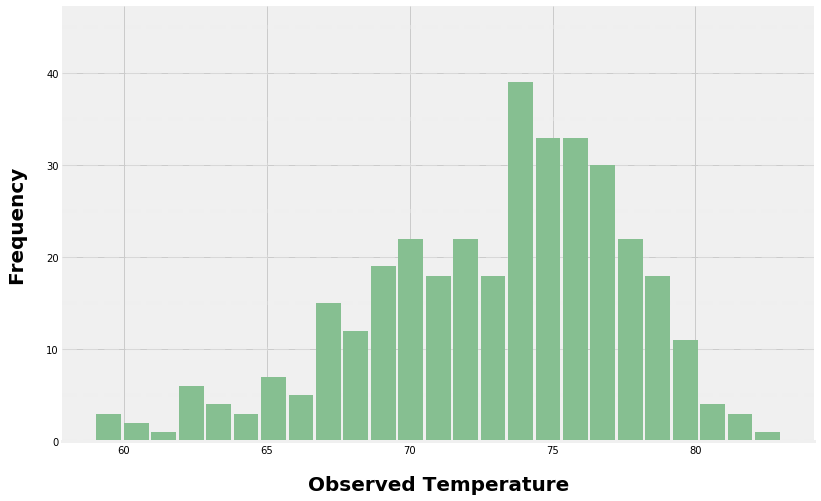

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_active_station = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).all()
max_active_station_df = pd.DataFrame(max_active_station, columns=['Station', 'T_Meas_Count'])
max_active_station=max_active_station_df.iloc[max_active_station_df['T_Meas_Count'].idxmax()]
#print(max_active_station[0])
sel = [Measurement.station, 
       Measurement.tobs]
Temp_hist = session.query(*sel).filter(Measurement.station == max_active_station[0]).filter(Measurement.date > '2016-08-23').all()

Temp_hist_df = pd.DataFrame(Temp_hist, columns=['Station', 'T_Meas'])

ax = Temp_hist_df.hist(column='T_Meas',bins=25, grid=True, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]

for x in ax:
# Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Remove title
    x.set_title("")

# Set x-axis label
    x.set_xlabel("Observed Temperature", labelpad=20, weight='bold', size=20)

# Set y-axis label
    x.set_ylabel("Frequency", labelpad=20, weight='bold', size=20)

In [27]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date,end_date):
    # User defined dates.
    
    # Args:
    start_date = start_date #'2015-02-28'
   # query_start_date = dt.date(str(start_date)) - dt.timedelta(days=365)
    end_date = end_date #'2015-04-05'
    #query_end_date = dt.date(str(end_date) - dt.timedelta(days=365)
    session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
    # Returns TMIN, TAVG, and TMAX for a list of dates.
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2017-01-03', '2017-01-14'))

[(60.0, 68.35616438356165, 81.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-01-03', '2017-01-14'))

[(60.0, 68.35616438356165, 81.0)]


Text(0,0.5,'Temp (F)')

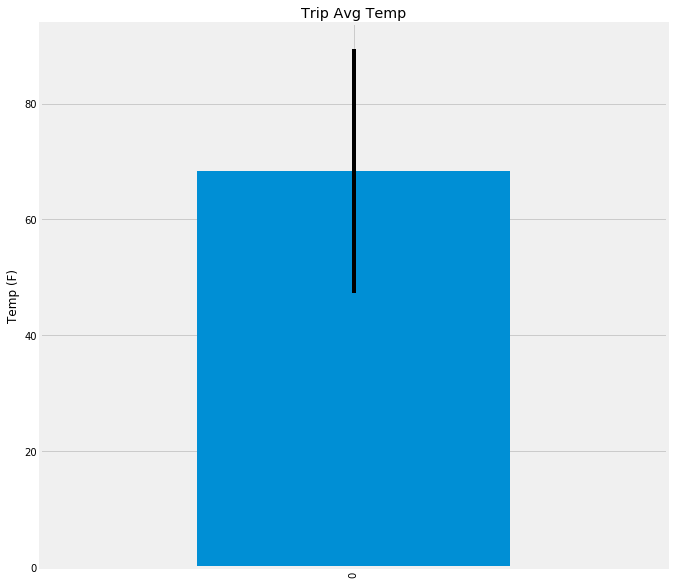

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
Trip_Avg_Temp = calc_temps('2017-01-03', '2017-01-14')
Trip_Avg_Temp_df = pd.DataFrame(Trip_Avg_Temp, columns=['Minimum Temp', 'Average Temp','Maximum Temp'])
Trip_Avg_Temp_df.head()

# Use Pandas Plotting with Matplotlib to plot the data 
ax = Trip_Avg_Temp_df['Average Temp'].plot.bar(figsize=(10,10),rot=90,yerr=(Trip_Avg_Temp_df['Maximum Temp']-Trip_Avg_Temp_df['Minimum Temp']) )

ax.title.set_text("Trip Avg Temp")

# Set y-axis label
ax.set_ylabel("Temp (F)")


In [52]:
# Calculate the rainfall per weather station for your trip dates 
# using the previous year's matching dates
# Sort this in descending order by precipitation amount and 
# list the station, name, latitude, longitude, and elevation


start_date = start_date #'2017-01-03'
   # query_start_date = dt.date(str(start_date)) - dt.timedelta(days=365)
end_date = end_date #'2017-01-14'
    
activity=func.count(Measurement.prcp)
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,
        activity]
results=[]
for row in session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Station.station).order_by(activity.desc()).all():
    #session.query(*sel).group_by(Measurement.station).order_by(activity.desc()).first():
    results.append(row)
results


[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 12),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  12),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  12),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 12),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  10),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  7),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
